In [60]:
import os
import numpy as np
import pandas as pd
import pickle
from time import sleep
from random import randint

from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import config
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [61]:
#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

In [18]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
        
    except FileNotFoundError: 
        print("File not found!") 

In [140]:
## load data
indir_list = ['music/audio features_miri/', 'Data/audio_features2/', 'zoe/features/aaron_oh_experience/',
'zoe/features/party_songs/', 'zoe/features/playlists/', 'zoe/features/ultimate_party_mix/']

required_cols = ['id', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

infile_list = []
for indir in indir_list:
    infile_list += [f"{indir}{x}" for x in os.listdir(indir)]

dfs = []
for fname in infile_list:
    if fname.endswith(".csv"):
        tempdf = pd.read_csv(fname, index_col=None)
        dfs.append(tempdf[required_cols].drop_duplicates().reset_index(drop=True))
    
df = pd.concat(dfs, axis=0)
df = df.drop_duplicates().reset_index(drop=True)


### checking on the file system

```
## get info for values in columns:
## danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id

(da-ironhack) nina@Ninas-Air Song_Recommodation_Project % 

grep -C 1 6ZahQeSE8fqyvC0jKr7CHA Data/audio_features2/*.csv | cut -d, -f1-11,13 | cut -f 2- -d-

0.709,0.803,3,-5.862,0,0.0323,0.101,0.919,0.192,0.356,124.0,6j9smjwHuQRmb41odOHS8Q
6.678,1,0.045,0.0272,0.913,0.117,0.0296,123.978,6ZahQeSE8fqyvC0jKr7CHA
0.561,0.63,1,-8.019,0,0.0344,0.108,0.178,0.134,0.0378,121.998,6n7bXOBucoX8BOQ8kFopov

grep -C 1 6ZahQeSE8fqyvC0jKr7CHA zoe/features/*/*.csv | cut -d, -f1-11,13 | cut -f 2- -d-

0.528,0.608,2,-7.071,0,0.0283,0.0364,0.0194,0.112,0.0946,144.973,0mWXMQ8hrrAJfxN7LG2Wsk
6.672,1,0.0428,0.0185,0.926,0.115,0.0305,124.004,6ZahQeSE8fqyvC0jKr7CHA
0.741,0.902,6,-4.695,0,0.0551,0.0633,0.337,0.143,0.743,125.004,4UV5qm4XHQETdXrVZjIsSU

```
weird... I dunno, why would we get two slightly different records for the same id?


In [141]:
df.shape

(51524, 14)

In [135]:
df[df.isnull().any(axis=1)].shape

(0, 14)

In [136]:
df[df.id.duplicated()]

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
45022,6ZahQeSE8fqyvC0jKr7CHA,0.52,0.962,7,-6.672,1,0.0428,0.0185,0.926,0.115,0.0305,124.004,315861,4


In [142]:
df[df.id == '6ZahQeSE8fqyvC0jKr7CHA']

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
27319,6ZahQeSE8fqyvC0jKr7CHA,0.502,0.959,7,-6.678,1,0.0450,0.0272,0.913,0.117,0.0296,123.978,315877,4
45022,6ZahQeSE8fqyvC0jKr7CHA,0.520,0.962,7,-6.672,1,0.0428,0.0185,0.926,0.115,0.0305,124.004,315861,4


### FIX: ensure id values are unique (just drop one of the dups)

In [143]:
df = df.drop_duplicates('id').reset_index(drop=True)

In [144]:
df.shape

(51523, 14)

In [145]:
## aside: which one did we keep? first
df[df.id == '6ZahQeSE8fqyvC0jKr7CHA']

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
27319,6ZahQeSE8fqyvC0jKr7CHA,0.502,0.959,7,-6.678,1,0.045,0.0272,0.913,0.117,0.0296,123.978,315877,4


### But wait, there's still more duplication... keep unique features only

ie drop records that differ by id only

In [152]:
df[df.duration_ms == 256163]

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
2028,3YeJXuRSNS5FYwOsDu44kD,0.28,0.821,8,-2.864,0,0.111,0.167,0.0,0.139,0.254,181.444,256163,3
2293,4apiNNK0jp9uqn3JDG9My1,0.28,0.821,8,-2.864,0,0.111,0.167,0.0,0.139,0.254,181.444,256163,3


In [160]:
df[~df[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature']].duplicated()].shape

(51022, 14)

In [161]:
df = df[~df[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature']].duplicated()].reset_index(drop=True)

In [162]:
df.shape

(51022, 14)

## Prepare X

In [163]:
## drop id and keep the rest
X = df.drop('id', axis=1).reset_index(drop=True)

In [164]:
## confirm no null values
X[X.isnull().any(axis=1)].shape

(0, 13)

In [166]:
## confirm no duplicates
X[X.duplicated()].shape

(0, 13)

In [167]:
## normalize
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

In [168]:
scaler_filename =  "Model/big-scaler.pickle"
with open(scaler_filename, "wb") as f:
    pickle.dump(scaler,f)
print(f'Saved StandardScaler model as: {scaler_filename}')

Saved StandardScaler model as: Model/big-scaler.pickle


In [169]:
K = range(2, 13)
silhouette = []
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1337)
    kmeans.fit(X_scaled_df)
    
    filename = f"Model/big_kmeans_{k}.pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


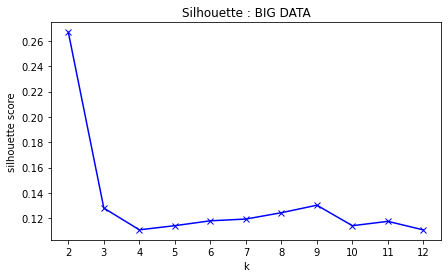

In [170]:
### ---- plot silhouette  ------
plt.figure(figsize=(7,4))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette : BIG DATA')
plt.show()

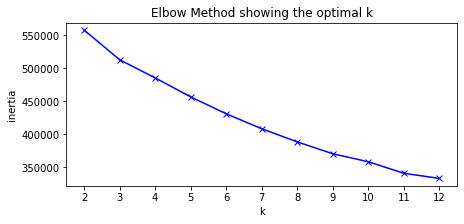

In [171]:
plt.figure(figsize=(7,3))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')
plt.show()

# Extract cluster label assignment for k=9

In [176]:
def assess_k_cluster_assignments(kval, df, X_scaled_df):
    ## load the trained model with the k == kval
    kmeans = load(f"Model/big_kmeans_{kval}.pickle")

    cluster_run_name = f'k{kval}_cluster'
    # create new col in main df with the cluster label the model assigned to each track
    df[cluster_run_name] = kmeans.labels_

    ## create dictionary of cluster membership for each label
    cluster_labels = np.unique(df[cluster_run_name])
    cluster_members = {}
    for cluster in cluster_labels:
        cluster_members[cluster] = np.where(df[cluster_run_name] == cluster)

    ## for each cluster label (ky) calculate the mean for each feature
    scaled_feature_means_by_cluster = pd.DataFrame([X_scaled_df.loc[cluster_members[ky]].mean(numeric_only=True) for ky in cluster_members.keys()])

    ## --- plot results as heatmap
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(15, 15))
        ax = sns.heatmap(scaled_feature_means_by_cluster, cmap='coolwarm', vmin=-1, vmax=1, annot=True, square=True)
        
    return df, scaled_feature_means_by_cluster
    

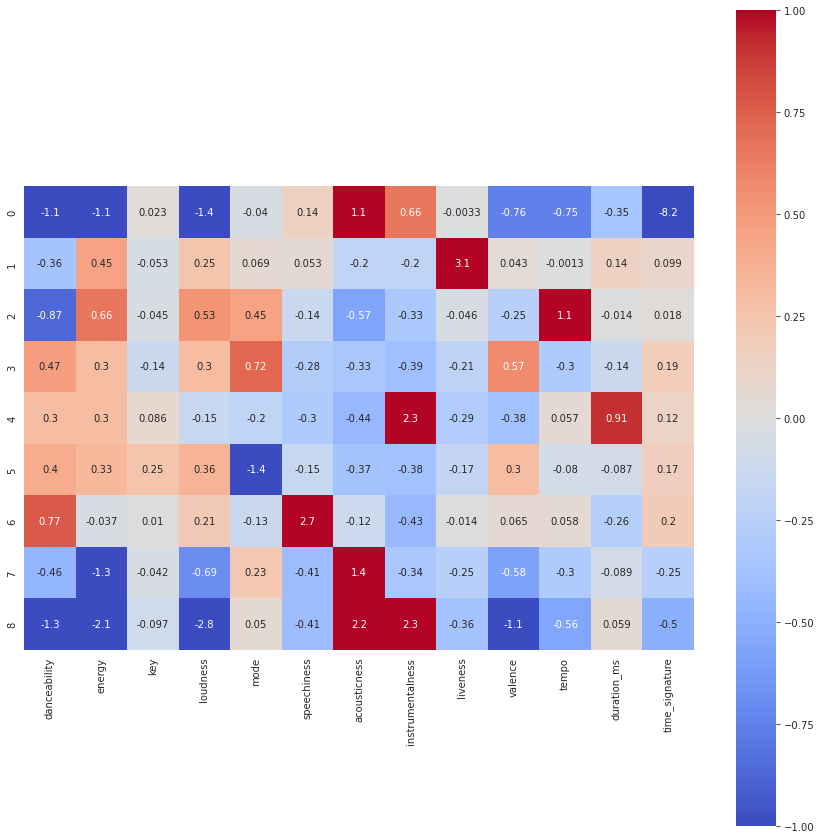

In [177]:
df, scaled_feature_means_by_cluster = assess_k_cluster_assignments(9, df, X_scaled_df)

In [179]:
df.k9_cluster.value_counts()

3    12998
5     9519
2     7553
7     6758
4     4329
6     4093
1     2853
8     2583
0      336
Name: k9_cluster, dtype: int64

## Save feature means to .csv

In [180]:
## Note: row index is cluster label, so include it in output
scaled_feature_means_by_cluster.to_csv('Model/k9_scaled_feature_means_by_cluster.csv')

# Save id and cluster assignments to .csv

In [181]:
## create smaller df with just the id and the cluster labels
id_and_labels_df = df[['id', 'k9_cluster']]
id_and_labels_df.shape

(51022, 2)

In [186]:
## check for null values -- nothing -- good
id_and_labels_df[id_and_labels_df.isnull().any(axis=1)]

,id,k9_cluster


In [187]:
## check for duplicated values -- nothing -- good
id_and_labels_df[id_and_labels_df.duplicated()]

,id,k9_cluster


In [183]:
id_and_labels_df.to_csv('Data/cluster_labels/deduped_big_data_id_and_cluster_labels.csv', index=False)

## Add artist name and track title 

In [48]:
df.columns

Index(['id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'k6_cluster',
       'k10_cluster'],
      dtype='object')

# Pasting together the artist-title-id info with the cluster labels

In [219]:
## load files with track artist and title data
indir = 'Data/artist_title_id/'
outdir = 'Data/db'

infile_list = os.listdir(indir)

dfs = []

all_ids_list = []
for fname in infile_list:
    if fname.endswith('.csv'):
        ## Load df with track artist and title
        fname_df = pd.read_csv(os.path.join(indir, fname), index_col=None)
                
        ## check for and handle NULL values
        fname_nulls = fname_df[fname_df.isnull().any(axis=1)]

        if fname_nulls.shape[0] > 0:
            null_outfilename = os.path.join(indir, 'null_records', fname.split('.')[0].split('_')[0]+"_nulls.csv")
            fname_nulls.to_csv(null_outfilename, index=False)
            print(f'Saved null records file ({fname_nulls.shape[0]}): {null_outfilename}')
            
            #drop the null records and continue
            fname_df = fname_df[~fname_df.isnull().any(axis=1)].reset_index(drop=True)

        ## deduplicate
        fname_df = fname_df.drop_duplicates().reset_index(drop=True)
        
        ## drop artist and track info for ids not in id_and_labels
        fname_df = fname_df[fname_df['id'].isin(id_and_labels_df.id.to_list())].reset_index(drop=True)
        
        ## load label and id info        
        my_info = id_and_labels_df[id_and_labels_df['id'].isin(fname_df.id.to_list())].reset_index(drop=True)
        all_ids_list += fname_df.id.to_list()
        
#         print(f"-------- DEBUG: my_info: {my_info.shape}\tfname_df: {fname_df.shape}")
        fname_df['k9_cluster'] = fname_df.id.map(my_info.set_index('id')['k9_cluster'])
        
        null_cluster_label = fname_df[fname_df['k9_cluster'].isnull()]

        if null_cluster_label.shape[0] > 0:
            print(f"ERROR!! Null values in cluster assignment!")
            
        else:
            outfilename = os.path.join(outdir, fname.split('.')[0].split('_')[0]+".csv")
            fname_df.to_csv(outfilename, index=False)
            print(f'Saved new DB file ({fname_df.shape[0]}): {outfilename}')

missing_track_info = id_and_labels_df[~id_and_labels_df['id'].isin(all_ids_list)].reset_index(drop=True)
missing_track_info.shape

Saved new DB file (14924): Data/db/batchA2.csv
Saved null records file (1): Data/artist_title_id/null_records/batchA1_nulls.csv
Saved new DB file (4996): Data/db/batchA1.csv
Saved new DB file (15588): Data/db/batchB.csv
Saved null records file (3): Data/artist_title_id/null_records/batchC_nulls.csv
Saved new DB file (15511): Data/db/batchC.csv


(4, 2)

In [198]:
missing_track_info

,id,k9_cluster
0,2qK37pJlCIgZ7uv4kheUXQ,6
1,7EQoRKZQ1Y792aF7B6nPS6,7
2,69gRFGOWY9OMpFJgFol1u0,3
3,6UA1pZet2JQSrvBGWx1F05,5


ok...we can live without those 4 tracks... move on to use these db files in the main loop